In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numpy import linalg as LA
import copy
import networkx as nx
import random

plt.rcParams.update({'font.size': 17})


from scipy.stats import pearsonr

In [4]:
#Read Supra adjacency matrix

corr_data = abs(pd.read_csv("../data/insulin_eQTL_spearman_corr_matrix_with_snap_removed_CF_lt_R_latest_10k_partial_cov.csv"))
corr_data

,RPL10P15,CYP17A1,RP1-197B17.7,PHF24,GNG3,NPPA,SYCE1,RP11-286H14.4,RP11-187C18.3,RPL29P12,...,STX5.1,EIF5A.1,MAPK7.1,HIPK1.1,STK36.1,POMGNT1.1,RRS1.1,NDUFAF7.1,PIK3CD.1,CAP1.1
RPL10P15,1.000000,0.053434,0.043760,0.050054,0.035954,0.046822,0.035239,0.118408,0.005489,0.194413,...,0.000727,0.070111,0.073198,0.065885,0.031846,0.003094,0.060211,0.075776,0.047379,0.066268
CYP17A1,0.053434,1.000000,0.040780,0.010423,0.114900,0.010247,0.052217,0.036745,0.136705,0.172469,...,0.007358,0.125375,0.057436,0.041594,0.071905,0.098046,0.037525,0.060133,0.018366,0.050969
RP1-197B17.7,0.043760,0.040780,1.000000,0.053669,0.104990,0.109487,0.113065,0.001620,0.075315,0.003869,...,0.014127,0.099711,0.008239,0.014327,0.031850,0.113746,0.032206,0.144107,0.038195,0.176731
PHF24,0.050054,0.010423,0.053669,1.000000,0.238854,0.046769,0.065840,0.034841,0.051371,0.001902,...,0.024330,0.034334,0.037916,0.001487,0.014788,0.052408,0.046394,0.075549,0.013842,0.057242
GNG3,0.035954,0.114900,0.104990,0.238854,1.000000,0.013479,0.028680,0.068333,0.071739,0.024476,...,0.134748,0.007479,0.062852,0.035041,0.045977,0.070340,0.083501,0.060685,0.042746,0.014760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POMGNT1,0.003094,0.098046,0.113746,0.052408,0.070340,0.051227,0.018045,0.004307,0.041205,0.021201,...,0.065954,0.256484,0.084094,0.000366,0.009958,1.000000,0.096197,0.046823,0.042183,0.231971
RRS1,0.060211,0.037525,0.032206,0.046394,0.083501,0.061765,0.000168,0.039143,0.074213,0.052205,...,0.253314,0.187179,0.146618,0.049679,0.103293,0.096197,1.000000,0.007978,0.070975,0.027322
NDUFAF7,0.075776,0.060133,0.144107,0.075549,0.060685,0.022735,0.059743,0.046151,0.000834,0.062077,...,0.067235,0.044782,0.029135,0.063853,0.046101,0.046823,0.007978,1.000000,0.124829,0.166220
PIK3CD,0.047379,0.018366,0.038195,0.013842,0.042746,0.060825,0.068878,0.037072,0.063950,0.064314,...,0.000115,0.009649,0.080346,0.028597,0.069386,0.042183,0.070975,0.124829,1.000000,0.080262


In [6]:
N = int(corr_data.shape[0])
L = 2
n = int(N/L)

In [8]:
# Load Insulin producing (source) and responding (target) genes

genes = list(corr_data.columns[:n])
target_genes = list(pd.read_csv('../data/insulin_target_genes_full.csv', header=None).iloc[:,0])
source_genes = list(pd.read_csv('../data/insulin_source_genes_full.csv', header=None).iloc[:,0])

print("Statistics of the ground truth data")
print("Number of genes: ", len(genes))
print("Number of target genes: ", len(target_genes))
print("Number of source genes: ", len(source_genes))
#print(genes)

common_target_genes = np.intersect1d(genes, target_genes)
common_source_genes = np.intersect1d(genes, source_genes)


print("Number of target genes present in the data: ", len(common_target_genes))
print("Number of source genes present in the data: ", len(common_source_genes))

target_genes_indices = [i for i, e in enumerate(genes) if e in common_target_genes]
source_genes_indices = [i for i, e in enumerate(genes) if e in common_source_genes]

print("Number of target genes present in the data: ", len(target_genes_indices))
print("Number of source genes present in the data: ", len(source_genes_indices))

print(target_genes_indices)

Statistics of the ground truth data
Number of genes:  14459
Number of target genes:  6482
Number of source genes:  2860
Number of target genes present in the data:  215
Number of source genes present in the data:  156
Number of target genes present in the data:  215
Number of source genes present in the data:  156
[5, 14, 1098, 1135, 1350, 1435, 1447, 1453, 1641, 1938, 2085, 2087, 2097, 2373, 2384, 2479, 2554, 2560, 2643, 2859, 2883, 3097, 3177, 3317, 3399, 3418, 3611, 3618, 3662, 3717, 3967, 4061, 4255, 4274, 4418, 4549, 4627, 4693, 5121, 5224, 5379, 5483, 5630, 5654, 5713, 6020, 6109, 6111, 6169, 6249, 6258, 6324, 6434, 6630, 6731, 6853, 6860, 6892, 6997, 7176, 7282, 7373, 7394, 7462, 7511, 7596, 7710, 7750, 7843, 7872, 7875, 8066, 8336, 8360, 8454, 8472, 8523, 8584, 8589, 8605, 8665, 8742, 8746, 8764, 8852, 8969, 9157, 9258, 9268, 9363, 9364, 9540, 9592, 9600, 9716, 9730, 9735, 9748, 9761, 9836, 9871, 9933, 10049, 10057, 10089, 10145, 10237, 10241, 10345, 10500, 10560, 10612, 10620,

In [9]:
# Load SNAP data. This includes tissue specific gene-gene connections.

SNAP_data = pd.read_csv("../data/SNAP_data/PPT-Ohmnet_gene_symbols.csv", index_col=0)
#SNAP_data
pancreas_df = SNAP_data.loc[SNAP_data['tissue'] == "pancreas"].values
skeletal_muscle_df = SNAP_data.loc[SNAP_data['tissue'] == "skeletal_muscle"].values

A_SNAP = np.zeros_like(corr_data.values, dtype=np.float32)



#skeletal_muscle_adjacency = np.zeros_like((np.shape(skeletal_muscle_df)[0], 2))
for i in range(np.shape(skeletal_muscle_df)[0]):
    n_offset = n
    try:
        from_gene = int(genes.index(skeletal_muscle_df[i,0])) + n_offset
        to_gene = int(genes.index(skeletal_muscle_df[i,1])) + n_offset    
        A_SNAP[from_gene, to_gene] = 1
        A_SNAP[to_gene, from_gene] = 1
    except:
        print("In skeletal muscle ", skeletal_muscle_df[i, 0], " or ", skeletal_muscle_df[i,1], " not present.")             
    

for i in range(np.shape(pancreas_df)[0]):
    n_offset = 0
    try:
        from_gene = int(genes.index(pancreas_df[i,0])) + n_offset
        to_gene = int(genes.index(pancreas_df[i,1])) + n_offset    
        A_SNAP[from_gene, to_gene] = 1
        A_SNAP[to_gene, from_gene] = 1
    except:
        print("In pancreas ", pancreas_df[i, 0], " or ", pancreas_df[i,1], " not present.")  


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In skeletal muscle  SETDB1  or  H4-16  not present.
In skeletal muscle  SEPTIN9  or  VAPB  not present.
In skeletal muscle  NKX3-2  or  TLE4  not present.
In skeletal muscle  MYOD1  or  RUNX1  not present.
In skeletal muscle  NPM1  or  ATP5F1A  not present.
In skeletal muscle  MRE11  or  FEN1  not present.
In skeletal muscle  RBPMS  or  TENT2  not present.
In skeletal muscle  ATP5F1D  or  ATP5F1C  not present.
In skeletal muscle  PPP1CA  or  PRKACG  not present.
In skeletal muscle  GCK  or  GMIP  not present.
In skeletal muscle  ERCC4  or  H2AX  not present.
In skeletal muscle  TLE5  or  RNF31  not present.
In skeletal muscle  GRB2  or  DENND2B  not present.
In skeletal muscle  FOXA3  or  DSP  not present.
In skeletal muscle  H4-16  or  KDM4A  not present.
In skeletal muscle  OBSL1  or  MRE11  not present.
In skeletal muscle  CREB3  or  BIK  not present.
In skeletal muscle  ACTN3  or  LHX3  not present.
In skeletal muscle  PRKN  or  EPS15  not present.
In skeletal muscle  PRKN  or  NME

In skeletal muscle  H2AX  or  HEXA  not present.
In skeletal muscle  HDAC1  or  H4C5  not present.
In skeletal muscle  L3MBTL1  or  H4C12  not present.
In skeletal muscle  TFEB  or  ATP5PF  not present.
In skeletal muscle  BMI1  or  ATP5ME  not present.
In skeletal muscle  MRPL58  or  ATP5MG  not present.
In skeletal muscle  SEM1  or  HSPA8  not present.
In skeletal muscle  ECPAS  or  KIF1B  not present.
In skeletal muscle  HDAC5  or  H4C3  not present.
In skeletal muscle  FYN  or  PAX7  not present.
In skeletal muscle  COPS5  or  H4C3  not present.
In skeletal muscle  ATP5MG  or  ATP5MF  not present.
In skeletal muscle  CAND1  or  H4C11  not present.
In skeletal muscle  RNF2  or  WASHC1  not present.
In skeletal muscle  NCK1  or  PAX3  not present.
In skeletal muscle  H4C1  or  CUL1  not present.
In skeletal muscle  MTOR  or  PRKN  not present.
In skeletal muscle  TUBG1  or  H4C8  not present.
In skeletal muscle  YWHAE  or  TGFB1  not present.
In skeletal muscle  P2RX2  or  P2RX2  not

In skeletal muscle  PRKN  or  ATP5F1C  not present.
In skeletal muscle  COPS5  or  H4C11  not present.
In skeletal muscle  NRG1  or  ATP7B  not present.
In skeletal muscle  PFKL  or  PRKACG  not present.
In skeletal muscle  CAND1  or  H4C12  not present.
In skeletal muscle  CBLC  or  ITCH  not present.
In skeletal muscle  CD81  or  ATP5PO  not present.
In skeletal muscle  RB1CC1  or  NSD3  not present.
In skeletal muscle  PFKM  or  CAV3  not present.
In skeletal muscle  ECPAS  or  MARCHF5  not present.
In skeletal muscle  NASP  or  H4C1  not present.
In skeletal muscle  MAPK1  or  GATA4  not present.
In skeletal muscle  MAP3K1  or  H4C5  not present.
In skeletal muscle  EGFR  or  ATP5PB  not present.
In skeletal muscle  PIK3CA  or  ATP5IF1  not present.
In skeletal muscle  NPHP1  or  DNAAF10  not present.
In skeletal muscle  TLE5  or  TCF7L2  not present.
In skeletal muscle  PRKN  or  STUB1  not present.
In skeletal muscle  APP  or  ATP5PO  not present.
In skeletal muscle  PGAM2  or  M

In skeletal muscle  EHD1  or  WARS1  not present.
In skeletal muscle  ATP5F1D  or  DDOST  not present.
In skeletal muscle  MYOD1  or  NCOR2  not present.
In skeletal muscle  PRKN  or  PSMD10  not present.
In skeletal muscle  MRPL58  or  ATP5F1B  not present.
In skeletal muscle  H2AX  or  EGFR  not present.
In skeletal muscle  PRKACG  or  PTPN12  not present.
In skeletal muscle  NSD2  or  CTNNB1  not present.
In skeletal muscle  EIF3E  or  ATP5F1A  not present.
In skeletal muscle  KPNA4  or  EXO1  not present.
In skeletal muscle  BRCA1  or  H4C3  not present.
In skeletal muscle  PRMT5  or  H4C11  not present.
In skeletal muscle  COPRS  or  H4C1  not present.
In skeletal muscle  GRB2  or  ATP5F1A  not present.
In skeletal muscle  SCUBE1  or  SCUBE1  not present.
In skeletal muscle  PRMT5  or  IGF2BP1  not present.
In skeletal muscle  KMT5A  or  H4C12  not present.
In skeletal muscle  BIK  or  CXCL16  not present.
In skeletal muscle  EGFR  or  ATP5F1A  not present.
In skeletal muscle  IGF

In skeletal muscle  UBASH3A  or  DTX3  not present.
In skeletal muscle  SEM1  or  EEF1G  not present.
In skeletal muscle  PICK1  or  ATP5IF1  not present.
In skeletal muscle  IGF2BP1  or  RPS27L  not present.
In skeletal muscle  WWOX  or  PLSCR3  not present.
In skeletal muscle  ATP5PO  or  NDUFS4  not present.
In skeletal muscle  INSR  or  CAV3  not present.
In skeletal muscle  FN1  or  ATP5F1A  not present.
In skeletal muscle  PRKN  or  DLG4  not present.
In skeletal muscle  KDM5B  or  SLITRK3  not present.
In skeletal muscle  ATP5F1A  or  ATP5F1B  not present.
In skeletal muscle  CUL1  or  IGF2BP1  not present.
In skeletal muscle  NSD2  or  DDX20  not present.
In skeletal muscle  LMX1A  or  LDB1  not present.
In skeletal muscle  SUMO2  or  BABAM2  not present.
In skeletal muscle  OBSL1  or  SEPTIN9  not present.
In skeletal muscle  WASHC1  or  BECN1  not present.
In skeletal muscle  ATP5F1A  or  VIM  not present.
In skeletal muscle  PIN1  or  ATP5F1B  not present.
In skeletal muscle

In skeletal muscle  INTS10  or  BRCA2  not present.
In skeletal muscle  CIDEB  or  DFFA  not present.
In skeletal muscle  BIK  or  VAMP5  not present.
In skeletal muscle  SMC3  or  SYCP3  not present.
In skeletal muscle  PRKN  or  SEPTIN5  not present.
In skeletal muscle  PHB2  or  ATP5F1C  not present.
In skeletal muscle  BRCA2  or  POLH  not present.
In skeletal muscle  GOLT1B  or  ATP5F1A  not present.
In skeletal muscle  NRG1  or  ZDHHC17  not present.
In skeletal muscle  H4C14  or  KDM4A  not present.
In skeletal muscle  HSD17B12  or  ATP5F1C  not present.
In skeletal muscle  TRIM24  or  H4C12  not present.
In skeletal muscle  GRB2  or  KRT9  not present.
In skeletal muscle  LHX3  or  ABI2  not present.
In skeletal muscle  NSD2  or  PTPN13  not present.
In skeletal muscle  PAK1  or  nan  not present.
In skeletal muscle  CIDEA  or  CIDEB  not present.
In skeletal muscle  SEM1  or  YY1  not present.
In skeletal muscle  HDAC5  or  H4C9  not present.
In skeletal muscle  IGF2BP1  or  R

In skeletal muscle  ATP5F1C  or  RPS3A  not present.
In skeletal muscle  HDAC6  or  H4C11  not present.
In skeletal muscle  NKX3-2  or  SIN3A  not present.
In skeletal muscle  ZACN  or  DNAJB9  not present.
In skeletal muscle  ATP5PB  or  NDUFS4  not present.
In skeletal muscle  MOV10  or  IGF2BP1  not present.
In skeletal muscle  ATP5PB  or  CLIC1  not present.
In skeletal muscle  RARA  or  ALX1  not present.
In skeletal muscle  PAK1  or  H4C1  not present.
In skeletal muscle  CSNK2A1  or  ATP5F1A  not present.
In skeletal muscle  FOXE1  or  RIF1  not present.
In skeletal muscle  MAPK14  or  STAB2  not present.
In skeletal muscle  BLM  or  H2AX  not present.
In skeletal muscle  PRKN  or  UBE2D2  not present.
In skeletal muscle  PRKN  or  RUVBL1  not present.
In skeletal muscle  PSME3  or  ATP5F1B  not present.
In skeletal muscle  P2RY12  or  ATP5PB  not present.
In skeletal muscle  PRKN  or  VDAC1  not present.
In skeletal muscle  H4C5  or  SMARCA5  not present.
In skeletal muscle  BI

In skeletal muscle  MGRN1  or  MRAP  not present.
In skeletal muscle  BRCA1  or  H4C13  not present.
In skeletal muscle  GATA4  or  MAPK3  not present.
In skeletal muscle  STING1  or  DDOST  not present.
In skeletal muscle  CUL3  or  H4C14  not present.
In skeletal muscle  TLE5  or  PITX1  not present.
In skeletal muscle  ATR  or  BRCA2  not present.
In skeletal muscle  MARCHF5  or  CCNB1  not present.
In skeletal muscle  RB1  or  H4-16  not present.
In skeletal muscle  COPRS  or  H4C11  not present.
In skeletal muscle  CAND1  or  H4C1  not present.
In skeletal muscle  UBE2K  or  CBLC  not present.
In skeletal muscle  KDM1A  or  NSD2  not present.
In skeletal muscle  IGF2BP1  or  SCYL2  not present.
In skeletal muscle  MARCHF5  or  UBE2E3  not present.
In skeletal muscle  MAP3K3  or  H4C4  not present.
In skeletal muscle  BRCA1  or  H4C1  not present.
In skeletal muscle  MED4  or  ATP5PB  not present.
In skeletal muscle  ATP5PB  or  TOMM20  not present.
In skeletal muscle  PRKN  or  MA

In skeletal muscle  SEM1  or  SUMO2  not present.
In skeletal muscle  LIN7B  or  PALS1  not present.
In skeletal muscle  YY1  or  LHX3  not present.
In skeletal muscle  ATP5F1C  or  APP  not present.
In skeletal muscle  ATP5PD  or  NDUFA12  not present.
In skeletal muscle  SET  or  H4C14  not present.
In skeletal muscle  ATL3  or  ATP5F1E  not present.
In skeletal muscle  PRKN  or  YWHAH  not present.
In skeletal muscle  USF1  or  ATP5PD  not present.
In skeletal muscle  PRKN  or  REL  not present.
In skeletal muscle  SKI  or  ATP5F1A  not present.
In skeletal muscle  PRKN  or  RAD1  not present.
In skeletal muscle  CCN2  or  TGFB3  not present.
In skeletal muscle  IGF2BP1  or  SF3B1  not present.
In skeletal muscle  POGZ  or  A1CF  not present.
In skeletal muscle  GNAS  or  CAV3  not present.
In skeletal muscle  COPRS  or  H4C12  not present.
In skeletal muscle  CDK2  or  ATP5F1D  not present.
In skeletal muscle  FOXE1  or  RCC1  not present.
In skeletal muscle  MRTFB  or  SRF  not pr

In skeletal muscle  NKX3-2  or  RBBP7  not present.
In skeletal muscle  BCL2L1  or  BIK  not present.
In skeletal muscle  TLE5  or  HGS  not present.
In skeletal muscle  MARCHF2  or  UBE2D1  not present.
In skeletal muscle  ATP1A1  or  ATP5MG  not present.
In skeletal muscle  TLE5  or  GIGYF1  not present.
In skeletal muscle  COPS5  or  H4C14  not present.
In skeletal muscle  CLDN3  or  TJP1  not present.
In skeletal muscle  ATP5F1A  or  PABPC1  not present.
In skeletal muscle  RXRA  or  MYOD1  not present.
In skeletal muscle  FYN  or  BRCA2  not present.
In skeletal muscle  NRG1  or  LEMD3  not present.
In skeletal muscle  SUMO1  or  PRKN  not present.
In skeletal muscle  EP300  or  ALX1  not present.
In skeletal muscle  HDAC1  or  H4C14  not present.
In skeletal muscle  MAPK1  or  MRTFA  not present.
In skeletal muscle  PIN1  or  PRKACG  not present.
In skeletal muscle  AKTIP  or  TWNK  not present.
In skeletal muscle  NMT1  or  MRE11  not present.
In skeletal muscle  DHRS2  or  DHRS

In skeletal muscle  WWTR1  or  PAX3  not present.
In skeletal muscle  SEPTIN5  or  PFN2  not present.
In skeletal muscle  SMAD7  or  MYOD1  not present.
In skeletal muscle  USP11  or  MRE11  not present.
In skeletal muscle  COPRS  or  H4C4  not present.
In skeletal muscle  ECPAS  or  RPS26  not present.
In skeletal muscle  SLC9A2  or  RASA1  not present.
In skeletal muscle  SEM1  or  TRIM33  not present.
In skeletal muscle  AGO4  or  ATP5F1C  not present.
In skeletal muscle  CDK2  or  ATP5PB  not present.
In skeletal muscle  ATP5F1B  or  PHB  not present.
In skeletal muscle  STAB2  or  SUMO1  not present.
In skeletal muscle  CDH23  or  USH1C  not present.
In skeletal muscle  PRKN  or  RHOT2  not present.
In skeletal muscle  VDAC1  or  ATP5F1A  not present.
In skeletal muscle  DNAAF4  or  NCK2  not present.
In skeletal muscle  PRKN  or  PRPF19  not present.
In skeletal muscle  PRKACG  or  CCND1  not present.
In skeletal muscle  RBBP7  or  H4-16  not present.
In skeletal muscle  SGO1  or

In skeletal muscle  CAND1  or  H4C3  not present.
In skeletal muscle  ATF2  or  H2AX  not present.
In skeletal muscle  MCM2  or  H4C3  not present.
In skeletal muscle  H4C6  or  SETDB1  not present.
In skeletal muscle  IGF2BP1  or  WDR77  not present.
In skeletal muscle  ATP5F1C  or  EIF4A3  not present.
In skeletal muscle  SHANK1  or  TRAF2  not present.
In skeletal muscle  MYOCD  or  MRTFA  not present.
In skeletal muscle  ATP5F1D  or  ATG5  not present.
In skeletal muscle  FOXE1  or  SMARCA5  not present.
In skeletal muscle  ATP5F1E  or  ATP5PF  not present.
In skeletal muscle  H2AX  or  HSP90AA1  not present.
In skeletal muscle  MYH10  or  SEPTIN7  not present.
In skeletal muscle  ELP1  or  PSMB5  not present.
In skeletal muscle  PPP1CC  or  ATP5F1B  not present.
In skeletal muscle  FOXE1  or  SIX1  not present.
In skeletal muscle  SP1  or  BRCA2  not present.
In skeletal muscle  BABAM2  or  PHB  not present.
In skeletal muscle  COPS5  or  H4C9  not present.
In skeletal muscle  MCM

In skeletal muscle  H2AX  or  H2AX  not present.
In skeletal muscle  TP53BP2  or  UBASH3A  not present.
In skeletal muscle  TNFRSF1A  or  H4C8  not present.
In skeletal muscle  PGAM2  or  PGAM2  not present.
In skeletal muscle  TGFB1  or  LAMC1  not present.
In skeletal muscle  SEM1  or  UBE2G2  not present.
In skeletal muscle  CEP250  or  IGF2BP1  not present.
In skeletal muscle  PAXIP1  or  BABAM2  not present.
In skeletal muscle  EGFR  or  ATP5MG  not present.
In skeletal muscle  GRB2  or  BABAM2  not present.
In skeletal muscle  RET  or  CBLC  not present.
In skeletal muscle  CALCOCO2  or  TENT2  not present.
In skeletal muscle  PALB2  or  BRCA2  not present.
In skeletal muscle  FOXA3  or  SMPD4  not present.
In skeletal muscle  OVCA2  or  PTPN11  not present.
In skeletal muscle  JAK2  or  SH2B2  not present.
In skeletal muscle  CREBBP  or  H4-16  not present.
In skeletal muscle  HDAC5  or  H4C4  not present.
In skeletal muscle  SERPINH1  or  BRCA2  not present.
In skeletal muscle 

In skeletal muscle  DHRS2  or  DDX5  not present.
In skeletal muscle  PLA2G3  or  TGFB1I1  not present.
In skeletal muscle  PRKN  or  CHCHD3  not present.
In skeletal muscle  COPS5  or  H4C5  not present.
In skeletal muscle  LHX1  or  RLIM  not present.
In skeletal muscle  CAND1  or  H4C2  not present.
In skeletal muscle  MYOD1  or  CDK1  not present.
In skeletal muscle  DNM2  or  SHANK1  not present.
In skeletal muscle  H2AX  or  YWHAB  not present.
In skeletal muscle  SMAD1  or  MRTFB  not present.
In skeletal muscle  SEM1  or  ADRM1  not present.
In skeletal muscle  CUL3  or  H4C13  not present.
In skeletal muscle  PRKN  or  ATXN2  not present.
In skeletal muscle  KIAA0319  or  SH2B1  not present.
In skeletal muscle  MRTFA  or  MRTFB  not present.
In skeletal muscle  UBASH3A  or  UBASH3A  not present.
In skeletal muscle  KAT2A  or  H4C1  not present.
In skeletal muscle  EZH2  or  MYOD1  not present.
In skeletal muscle  FOXE1  or  CDC27  not present.
In skeletal muscle  ATP5F1C  or  

In skeletal muscle  ATP5F1C  or  POLA2  not present.
In skeletal muscle  AARS1  or  WARS1  not present.
In skeletal muscle  ATP5F1B  or  VCL  not present.
In skeletal muscle  YBX3  or  MRE11  not present.
In skeletal muscle  HDAC6  or  H4C15  not present.
In skeletal muscle  ATP5PB  or  ATP5F1A  not present.
In skeletal muscle  RNF2  or  H4-16  not present.
In skeletal muscle  HDAC5  or  H4C15  not present.
In skeletal muscle  H4-16  or  SRC  not present.
In skeletal muscle  LIMK1  or  NRG1  not present.
In skeletal muscle  BRCA1  or  H4C12  not present.
In skeletal muscle  ANXA6  or  ATP5F1A  not present.
In skeletal muscle  L3MBTL1  or  H4C3  not present.
In skeletal muscle  NSD2  or  KIF11  not present.
In skeletal muscle  TNFRSF1A  or  H4C12  not present.
In skeletal muscle  AFG3L2  or  ATP5F1A  not present.
In skeletal muscle  H2AX  or  HNRNPA1  not present.
In skeletal muscle  DHRS2  or  HSPA8  not present.
In skeletal muscle  ATP5IF1  or  ATP5MF  not present.
In skeletal muscle 

In skeletal muscle  LIN7C  or  KIF26B  not present.
In skeletal muscle  BRCA2  or  SMAD2  not present.
In skeletal muscle  CAND1  or  H4C15  not present.
In skeletal muscle  FOXE1  or  HOXC13  not present.
In skeletal muscle  KAT6B  or  CTNNA3  not present.
In skeletal muscle  PRXL2B  or  HRAS  not present.
In skeletal muscle  H4C1  or  XPO7  not present.
In skeletal muscle  LRRK2  or  PRKN  not present.
In skeletal muscle  HDAC5  or  ATP5F1B  not present.
In skeletal muscle  VPS26A  or  WASHC2C  not present.
In skeletal muscle  SLC4A1  or  HBA1  not present.
In skeletal muscle  ANXA2  or  ATP5F1A  not present.
In skeletal muscle  KDM3A  or  MRTFA  not present.
In skeletal muscle  H2AX  or  TMX1  not present.
In pancreas  SETDB1  or  H4-16  not present.
In pancreas  SEPTIN9  or  VAPB  not present.
In pancreas  NKX3-2  or  TLE4  not present.
In pancreas  ALYREF  or  ERCC4  not present.
In pancreas  NPM1  or  ATP5F1A  not present.
In pancreas  MRE11  or  FEN1  not present.
In pancreas  R

In pancreas  FANCD2  or  MRE11  not present.
In pancreas  CDK2  or  ATP5MG  not present.
In pancreas  TAFAZZIN  or  COL6A2  not present.
In pancreas  TRPV5  or  USF2  not present.
In pancreas  ALYREF  or  ALYREF  not present.
In pancreas  KRT18  or  USH2A  not present.
In pancreas  PSMA2  or  ECPAS  not present.
In pancreas  GRB2  or  H4C2  not present.
In pancreas  ZACN  or  EDA  not present.
In pancreas  H4C11  or  SMARCA5  not present.
In pancreas  HNF4A  or  TP53  not present.
In pancreas  HDAC1  or  H4C12  not present.
In pancreas  RASGRF1  or  YWHAE  not present.
In pancreas  UBD  or  PSMC3  not present.
In pancreas  ARRB2  or  ALYREF  not present.
In pancreas  TRIM23  or  ATP5PF  not present.
In pancreas  TNFRSF1A  or  H4C9  not present.
In pancreas  PRKN  or  PSME1  not present.
In pancreas  NCOA3  or  MRTFA  not present.
In pancreas  STN1  or  MED13  not present.
In pancreas  MAPK1  or  STAB2  not present.
In pancreas  ISL1  or  APP  not present.
In pancreas  H2AX  or  HEXA  n

In pancreas  CD81  or  ATP5PO  not present.
In pancreas  ALYREF  or  CDK12  not present.
In pancreas  RB1CC1  or  NSD3  not present.
In pancreas  ECPAS  or  MARCHF5  not present.
In pancreas  LMX1B  or  PBX3  not present.
In pancreas  NASP  or  H4C1  not present.
In pancreas  MAPK1  or  GATA4  not present.
In pancreas  MAP3K1  or  H4C5  not present.
In pancreas  EGFR  or  ATP5PB  not present.
In pancreas  PIK3CA  or  ATP5IF1  not present.
In pancreas  TLE5  or  TCF7L2  not present.
In pancreas  PRKN  or  STUB1  not present.
In pancreas  APP  or  ATP5PO  not present.
In pancreas  PGAM2  or  MDM2  not present.
In pancreas  ATP6V0D1  or  ATP5PO  not present.
In pancreas  PRKN  or  TUBG1  not present.
In pancreas  H2AX  or  NHEJ1  not present.
In pancreas  H2AX  or  PRDX3  not present.
In pancreas  H2AX  or  S100A4  not present.
In pancreas  HDAC5  or  ATP5F1A  not present.
In pancreas  H2AX  or  PML  not present.
In pancreas  DNAAF10  or  UBE3C  not present.
In pancreas  SUZ12  or  TGFB1 

In pancreas  ALYREF  or  CPSF6  not present.
In pancreas  ARRB1  or  H4C12  not present.
In pancreas  HSPA9  or  PRKN  not present.
In pancreas  H4C3  or  KDM4A  not present.
In pancreas  MYO3A  or  TGFBR1  not present.
In pancreas  ISL1  or  ISL1  not present.
In pancreas  TNRC6A  or  A1CF  not present.
In pancreas  MARCHF6  or  SHC1  not present.
In pancreas  FOS  or  PRKACG  not present.
In pancreas  MCM2  or  H4-16  not present.
In pancreas  CLN3  or  ATP5MG  not present.
In pancreas  HDAC1  or  H4C15  not present.
In pancreas  GBA  or  PRKN  not present.
In pancreas  EHD1  or  WARS1  not present.
In pancreas  ATP5F1D  or  DDOST  not present.
In pancreas  PRKN  or  PSMD10  not present.
In pancreas  MRPL58  or  ATP5F1B  not present.
In pancreas  HSPA9  or  ALYREF  not present.
In pancreas  H2AX  or  EGFR  not present.
In pancreas  UBD  or  MAD2L1  not present.
In pancreas  PRKACG  or  PTPN12  not present.
In pancreas  PRKCA  or  TRPV5  not present.
In pancreas  NSD2  or  CTNNB1  not

In pancreas  ATP5PO  or  TRIP6  not present.
In pancreas  CDKN1A  or  ATP5F1B  not present.
In pancreas  KDM4A  or  H4C1  not present.
In pancreas  CYP1A2  or  PTGS1  not present.
In pancreas  RXFP3  or  RXFP3  not present.
In pancreas  SEM1  or  EEF1G  not present.
In pancreas  MARCHF4  or  UBE2D1  not present.
In pancreas  PICK1  or  ATP5IF1  not present.
In pancreas  WWOX  or  PLSCR3  not present.
In pancreas  ATP5PO  or  NDUFS4  not present.
In pancreas  FN1  or  ATP5F1A  not present.
In pancreas  PRKN  or  DLG4  not present.
In pancreas  LMX1B  or  TCF3  not present.
In pancreas  ATP5F1A  or  ATP5F1B  not present.
In pancreas  NSD2  or  DDX20  not present.
In pancreas  LMX1A  or  LDB1  not present.
In pancreas  SUMO2  or  BABAM2  not present.
In pancreas  SLC2A2  or  KPNA2  not present.
In pancreas  OBSL1  or  SEPTIN9  not present.
In pancreas  WASHC1  or  BECN1  not present.
In pancreas  ATP5F1A  or  VIM  not present.
In pancreas  PIN1  or  ATP5F1B  not present.
In pancreas  ALG2

In pancreas  MCM2  or  H4C15  not present.
In pancreas  RASGRF1  or  YWHAB  not present.
In pancreas  PTPA  or  H2AX  not present.
In pancreas  HNF4A  or  SNCG  not present.
In pancreas  PTF1A  or  RBPJ  not present.
In pancreas  RPS6KB2  or  NPY4R  not present.
In pancreas  TRAF3  or  STING1  not present.
In pancreas  BRD7  or  H4C14  not present.
In pancreas  SH2D1A  or  LHX3  not present.
In pancreas  CTNND1  or  CDH3  not present.
In pancreas  PPM1D  or  NSD3  not present.
In pancreas  VDAC1  or  ATP5F1B  not present.
In pancreas  TAFAZZIN  or  CSNK1E  not present.
In pancreas  ALYREF  or  SNRNP70  not present.
In pancreas  CTNNB1  or  PRKN  not present.
In pancreas  HSPB1  or  ECPAS  not present.
In pancreas  SMAD4  or  RAB3B  not present.
In pancreas  RP2  or  ECPAS  not present.
In pancreas  ZACN  or  TRPM7  not present.
In pancreas  TRIM32  or  STING1  not present.
In pancreas  PRMT5  or  H4C1  not present.
In pancreas  MAP3K3  or  H4C8  not present.
In pancreas  ATP5MG  or  MT

In pancreas  PRKN  or  MAPK1  not present.
In pancreas  ATP5IF1  or  ATP5IF1  not present.
In pancreas  ATP5MG  or  ATP5PD  not present.
In pancreas  RTN4  or  ATP5PO  not present.
In pancreas  SEM1  or  EIF3A  not present.
In pancreas  KAT2A  or  H4C14  not present.
In pancreas  PDX1  or  XRCC5  not present.
In pancreas  H4-16  or  BRD7  not present.
In pancreas  H4C9  or  APP  not present.
In pancreas  TLE5  or  SNRPC  not present.
In pancreas  NOX5  or  HSP90AA1  not present.
In pancreas  CUL3  or  H4C6  not present.
In pancreas  PRKDC  or  PDX1  not present.
In pancreas  TLE5  or  TNRC6A  not present.
In pancreas  PRPS1  or  PRKN  not present.
In pancreas  PRKN  or  HSP90AB1  not present.
In pancreas  PRKN  or  GPD2  not present.
In pancreas  GLP1R  or  CALM3  not present.
In pancreas  CBLC  or  FYN  not present.
In pancreas  PRKCA  or  CASR  not present.
In pancreas  TLE5  or  HDAC3  not present.
In pancreas  FBLN1  or  TDGF1  not present.
In pancreas  FBXO6  or  TGFB1  not presen

In pancreas  SMAD1  or  RAB3B  not present.
In pancreas  PRKN  or  SET  not present.
In pancreas  GNAI2  or  ECPAS  not present.
In pancreas  PRKN  or  PSMC2  not present.
In pancreas  HNF4A  or  TAF9  not present.
In pancreas  SEM1  or  PSMG2  not present.
In pancreas  TLE5  or  PFDN5  not present.
In pancreas  ELP1  or  PRKDC  not present.
In pancreas  SH2B2  or  JAK1  not present.
In pancreas  SRC  or  HNF1A  not present.
In pancreas  PRMT5  or  H4C13  not present.
In pancreas  TGFB1  or  NSD3  not present.
In pancreas  NCOR2  or  HNF4A  not present.
In pancreas  CERT1  or  TGM2  not present.
In pancreas  SH2B2  or  SH2B2  not present.
In pancreas  CTSE  or  BAG6  not present.
In pancreas  FN1  or  H4C14  not present.
In pancreas  ALYREF  or  THOC1  not present.
In pancreas  ATP5IF1  or  CAT  not present.
In pancreas  STING1  or  SGPL1  not present.
In pancreas  BRCA1  or  PAX2  not present.
In pancreas  PRKN  or  ATP5MF  not present.
In pancreas  CBLC  or  UBE2D1  not present.
In p

In pancreas  NKX3-2  or  RBBP4  not present.
In pancreas  CREBBP  or  HNF1A  not present.
In pancreas  NSD2  or  NSD2  not present.
In pancreas  ATP5F1B  or  ATP5PF  not present.
In pancreas  NEDD4  or  SEPTIN9  not present.
In pancreas  FOXE1  or  CREB1  not present.
In pancreas  ALYREF  or  NCBP2  not present.
In pancreas  ATP5F1A  or  PHB  not present.
In pancreas  BRCA2  or  SEM1  not present.
In pancreas  UCHL5  or  H4C13  not present.
In pancreas  ZWINT  or  CCN1  not present.
In pancreas  MMP7  or  TCF7L2  not present.
In pancreas  TLE5  or  EXOSC5  not present.
In pancreas  ZDHHC17  or  STN1  not present.
In pancreas  H2AX  or  PEF1  not present.
In pancreas  MAP3K1  or  H4C15  not present.
In pancreas  MAPK3  or  STAB2  not present.
In pancreas  MAPK3  or  H4C1  not present.
In pancreas  SHMT1  or  H4C1  not present.
In pancreas  TENT4B  or  NUMA1  not present.
In pancreas  MAPK8  or  STAB2  not present.
In pancreas  CSNK1D  or  PAK5  not present.
In pancreas  SUZ12  or  ALYRE

In pancreas  CREBBP  or  H4C1  not present.
In pancreas  FOXE1  or  UBP1  not present.
In pancreas  H4C6  or  DAXX  not present.
In pancreas  SEM1  or  PSMB4  not present.
In pancreas  DNAAF10  or  MAP3K3  not present.
In pancreas  H4-16  or  TNFRSF1A  not present.
In pancreas  SUZ12  or  H4-16  not present.
In pancreas  BIK  or  VAMP3  not present.
In pancreas  TGFB1  or  LAMB1  not present.
In pancreas  SEPTIN11  or  TOMM40  not present.
In pancreas  PXK  or  ALYREF  not present.
In pancreas  ATP5F1B  or  ATP5MG  not present.
In pancreas  SEM1  or  PSMA2  not present.
In pancreas  UBD  or  TGFBR1  not present.
In pancreas  MCM2  or  ATP5F1A  not present.
In pancreas  LRP1  or  PRKACG  not present.
In pancreas  H2AX  or  PLOD1  not present.
In pancreas  PRKN  or  XRCC6  not present.
In pancreas  ATP5PB  or  VHL  not present.
In pancreas  VEZF1  or  LHX3  not present.
In pancreas  RCOR1  or  BRCA2  not present.
In pancreas  ATP5F1C  or  PTN  not present.
In pancreas  SMAD3  or  LHX3  n

In pancreas  PABPC1  or  ATP5F1C  not present.
In pancreas  L3MBTL1  or  H4C9  not present.
In pancreas  FOXE1  or  KPNA6  not present.
In pancreas  NOX5  or  STUB1  not present.
In pancreas  STUB1  or  TERT  not present.
In pancreas  ATP5F1A  or  ATP5PD  not present.
In pancreas  SOD1  or  MARCHF5  not present.
In pancreas  H2AX  or  NPM1  not present.
In pancreas  TLE5  or  SKIL  not present.
In pancreas  CUL3  or  H4C11  not present.
In pancreas  FBXO6  or  H4C8  not present.
In pancreas  FN1  or  KRT9  not present.
In pancreas  CAND1  or  TUT4  not present.
In pancreas  BRCA2  or  USF1  not present.
In pancreas  LMX1B  or  LDB1  not present.
In pancreas  PRKACG  or  RAP1GAP  not present.
In pancreas  SIX2  or  TLE5  not present.
In pancreas  TLE5  or  PRKAA1  not present.
In pancreas  FOXA3  or  NUP107  not present.
In pancreas  PPP2CA  or  SGO1  not present.
In pancreas  NOX1  or  TNFRSF1A  not present.
In pancreas  GSK3A  or  PRKACG  not present.
In pancreas  ELP1  or  FLNA  not 

In pancreas  NCOR1  or  H4C1  not present.
In pancreas  GOLT1B  or  ATP5F1B  not present.
In pancreas  STING1  or  MAVS  not present.
In pancreas  MCM2  or  ATP5F1C  not present.
In pancreas  F11  or  HNF4A  not present.
In pancreas  FLNA  or  TGFB1  not present.
In pancreas  VDAC3  or  ATP5F1D  not present.
In pancreas  H2AX  or  YWHAE  not present.
In pancreas  TLE5  or  TSC22D4  not present.
In pancreas  KAT2A  or  H4-16  not present.
In pancreas  GLP1R  or  C18orf32  not present.
In pancreas  TLE5  or  PRPF31  not present.
In pancreas  BRCA1  or  H4C11  not present.
In pancreas  STAB2  or  SUMO3  not present.
In pancreas  MCM2  or  H4C14  not present.
In pancreas  COPS5  or  KRT9  not present.
In pancreas  PARP1  or  H4C1  not present.
In pancreas  DSP  or  OVCA2  not present.
In pancreas  TRIM24  or  H4C1  not present.
In pancreas  HIPK2  or  NKX3-2  not present.
In pancreas  FOXE1  or  SMARCA4  not present.
In pancreas  PRKN  or  VIM  not present.
In pancreas  FN1  or  H4C6  not 

In pancreas  JAK2  or  SH2B2  not present.
In pancreas  CREBBP  or  H4-16  not present.
In pancreas  HDAC5  or  H4C4  not present.
In pancreas  SERPINH1  or  BRCA2  not present.
In pancreas  HNF4A  or  MED21  not present.
In pancreas  BRAF  or  NSD2  not present.
In pancreas  KPNB1  or  SLC27A2  not present.
In pancreas  ILK  or  ATP5ME  not present.
In pancreas  GRIK2  or  PRKACG  not present.
In pancreas  NCOA3  or  MRTFB  not present.
In pancreas  CUL1  or  KRT9  not present.
In pancreas  ERCC3  or  MRE11  not present.
In pancreas  PRMT5  or  H4C6  not present.
In pancreas  MST1R  or  MST1  not present.
In pancreas  HSP90AB1  or  AARS1  not present.
In pancreas  ECPAS  or  TUBB  not present.
In pancreas  HNF4A  or  RAD50  not present.
In pancreas  MRE11  or  PRMT1  not present.
In pancreas  MARCHF4  or  UBE2H  not present.
In pancreas  KIF2A  or  TMPRSS3  not present.
In pancreas  CAND1  or  H4C14  not present.
In pancreas  APC  or  KRT9  not present.
In pancreas  CDH1  or  KRT9  no

In pancreas  ATP5F1D  or  ATP5MF  not present.
In pancreas  ATP5PF  or  PARK7  not present.
In pancreas  HDAC5  or  H4C5  not present.
In pancreas  BRCA1  or  H4C6  not present.
In pancreas  PPP1CB  or  PRKACG  not present.
In pancreas  H4C8  or  SMARCA5  not present.
In pancreas  H2AX  or  CUL1  not present.
In pancreas  PRKN  or  MRPL12  not present.
In pancreas  SALL3  or  DNMT3A  not present.
In pancreas  NPHS1  or  MAP2K6  not present.
In pancreas  PPP1CC  or  PRKACG  not present.
In pancreas  PRKN  or  VCP  not present.
In pancreas  LHX3  or  TSEN54  not present.
In pancreas  SUZ12  or  ATP5F1C  not present.
In pancreas  RNF2  or  ZFY  not present.
In pancreas  FOXA3  or  NSF  not present.
In pancreas  H4C14  or  SMARCA5  not present.
In pancreas  UIMC1  or  TGFB1  not present.
In pancreas  CLTC  or  ATP5F1C  not present.
In pancreas  ATP5MG  or  ATP5PB  not present.
In pancreas  FOXA3  or  P4HA1  not present.
In pancreas  COPS5  or  GALNT13  not present.
In pancreas  SEM1  or  T

In pancreas  PTBP1  or  ATP5F1B  not present.
In pancreas  ZACN  or  EDEM1  not present.
In pancreas  HNF4A  or  NCOA3  not present.
In pancreas  ANXA7  or  ATP5F1B  not present.
In pancreas  FOXE1  or  SMC4  not present.
In pancreas  PHLDA3  or  ATP5MG  not present.
In pancreas  DDX5  or  ATP5F1A  not present.
In pancreas  HNF1A  or  DYRK1B  not present.
In pancreas  MRE11  or  MLH1  not present.
In pancreas  CUL3  or  H4C2  not present.
In pancreas  SEM1  or  CUL1  not present.
In pancreas  ILK  or  ATP5F1A  not present.
In pancreas  NSD1  or  H4-16  not present.
In pancreas  DTX2  or  TENT2  not present.
In pancreas  SEM1  or  PSME3  not present.
In pancreas  ELP1  or  DYNC1H1  not present.
In pancreas  USP16  or  H4-16  not present.
In pancreas  EP300  or  H4-16  not present.
In pancreas  EPAS1  or  ELP1  not present.
In pancreas  TLE5  or  BCL6  not present.
In pancreas  OBSL1  or  H4C12  not present.
In pancreas  ATG5  or  ATP5MF  not present.
In pancreas  PRKN  or  RBCK1  not pr

In [10]:
lncRNAs = list(np.load("../data/paper/lncRNAs.npy"))

lncRNA_indices = []

# Iterate over lncRNAs
for i, lncRNA in enumerate(lncRNAs):
    # Check if the current lncRNA is present in the genes list
    if lncRNA in genes:
        # Get the index of the current lncRNA in the genes list
        index = genes.index(lncRNA)
        # Append the index to the lncRNA_indices list
        lncRNA_indices.append(index)
len(lncRNA_indices)

634

In [11]:
import numpy as np
from scipy.stats import hypergeom

# Input adjacency matrix A, sets of node indexes "source1" and "target1"
A = corr_data.values[:n,:n]
source1 = lncRNA_indices
target1 = source_genes_indices


# Number of edges between source1 and target1
num_edges = np.sum(A[np.ix_(source1, target1)])

# Total number of edges in the graph
num_total_edges = np.sum(A)

# Total number of nodes in the graph
num_nodes = A.shape[0]

# Number of nodes in source1
num_source1 = len(source1)

# Number of nodes in target1
num_target1 = len(target1)

# Number of trials (i.e. number of random sets to compare against)
num_trials = 100

# Number of edges in random sets
random_num_edges = []
for i in range(num_trials):
    # Generate a random set of source nodes of the same size as source1
    random_source = np.random.choice(np.setdiff1d(np.arange(num_nodes), source1), size=num_source1, replace=False)
    # Calculate the number of edges between the random sets
    random_num_edges.append(np.sum(A[np.ix_(random_source, target1)]))

# Calculate the p-value
p_value = np.sum(np.array(random_num_edges) >= num_edges) / num_trials

# Using Hypergeometric Distribution
p_value = 1 - hypergeom.cdf(num_edges-1, num_nodes, num_source1, num_target1)

# Print the p-value
print("p-value:", p_value)

p-value: 0.0


In [14]:
# Basic methods: These will be used while computing the centrality vector

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
#    return vector / np.max(vector)
    return vector / np.linalg.norm(vector)
    #return vector / np.linalg.norm(vector, ord=1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [15]:
# MultiCens local-set centrality

def right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    print("target tissue id")
    print(target_tissue)
    print("right_new_local_centrality")
    A_tilde_full = A_tilde_full/np.sum(A_tilde_full, axis=0)
    #A_tilde_full = A_tilde_full/LA.norm(A_tilde_full)
    num_target_genes = int(np.shape(target_gene_indices)[0])
    n = int(np.shape(A_tilde_full)[0]/num_layers)
    N = int(np.shape(A_tilde_full)[0])
    A_tilde = np.zeros_like(A_tilde_full, dtype=np.float32)
    
    if target_tissue == 1:
        A_tilde[n:,n:] = A_tilde_full[n:,n:]
    elif target_tissue == 0:
        A_tilde[:n,:n] = A_tilde_full[:n,:n]
    else:
        print("wrong target tissue")
    np.fill_diagonal(A_tilde, 0.0)
    #A_tilde = A_tilde/LA.norm(A_tilde)
    
    ones_t = np.zeros((N,))
    #ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    l = np.copy(ones_t)
    l_new = np.copy(ones_t)
    
    count = 0
    current_angle = np.zeros(3,)
    print("local centrality computation starts")
    while(count<70):
        print(count)
        count = count + 1
        l_new = (p* ((A_tilde).dot(l))) + (1-p)*ones_t
        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(l, l_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        l = copy.deepcopy(l_new)
        #l = copy.deepcopy(l_new)/LA.norm(l_new)
    print("l values")
    print(l)
    #new_l = l/l.sum()# + l_tt/l_tt.sum()
    new_l = copy.deepcopy(l)
    if target_tissue == 0:
        print("Found local centrality for target set centrality")
        new_l[:n] = l[:n]/l[:n].sum()
    elif target_tissue == 1:
        new_l[n:] = l[n:]/l[n:].sum()
        print("Found local centrality for source set centrality")
    else:
        print("invalid target tissue")
    print("Target genes")
    print(target_gene_indices)
    return new_l

In [17]:
# MultiCens global-set centrality

def right_target_global_centrality_t(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    l = right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    #A_tilde = copy.deepcopy(A_tilde_full)
    A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:,n:] = copy.deepcopy(A_tilde[n:,n:])
    C[:n,n:] = copy.deepcopy(A_tilde[:n,n:])
    C[n:,:n] = copy.deepcopy(A_tilde[n:,:n])
    
    
    print("finding source global centrality for layer " + str(target_tissue))
    
    ones_t = np.zeros((N,))
    #ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    while(counter<150):
        g_new = (p * ((A+C).dot(g) + (C.dot(l)) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    new_g = copy.deepcopy(g)
    if target_tissue == 1:
        print("Found target set centrality")
        new_g[:n] = g[:n]/g[:n].max()
    elif target_tissue == 0:
        new_g[n:] = g[n:]/g[n:].max()
        print("Found source set centrality")
    else:
        print("invalid target tissue")
    return l, new_g


In [25]:
# Implementation of RWR-h method

def rwr_mh(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    #l = right_new_local_centrality_st(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:,n:] = copy.deepcopy(A_tilde[n:,n:])
    C[:n,n:] = copy.deepcopy(A_tilde[:n,n:])
    C[n:,:n] = copy.deepcopy(A_tilde[n:,:n])

    A = np.nan_to_num(A/np.sum(A, axis=0))
    C = np.nan_to_num(C/np.sum(C, axis=0))
    
    print("finding source global centrality for layer " + str(target_tissue))
    
    ones_t = np.zeros((N,))
    ones_t[(np.asarray(target_gene_indices, dtype= np.int32) + int(n*target_tissue))] = 1/len(target_gene_indices)
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    counter = 0
    current_angle = np.zeros(3,)
    while(counter<150):
        g_new = (p * ((A+C).dot(g))) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    new_g = copy.deepcopy(g)
    if target_tissue == 1:
        print("Found target set centrality")
        new_g[:n] = g[:n]/g[:n].max()
    elif target_tissue == 0:
        new_g[n:] = g[n:]/g[n:].max()
        print("Found source set centrality")
    else:
        print("invalid target tissue")
    return new_g


In [ ]:
# Computation of local-set and query-set centrality vectors

A = np.zeros_like(corr_data.values)
A_orig = corr_data.values + A_SNAP
A[:n,:n] = A_orig[n:,n:]
A[:n,n:] = A_orig[n:,:n]
A[n:,:n] = A_orig[:n,n:]
A[n:,n:] = A_orig[:n,:n]

print("Swapping over")
l,g = right_target_global_centrality_t(A, num_layers=2, target_tissue = 1, target_gene_indices = source_genes_indices, p=0.9)


In [20]:
# MultiCens: local centrality

def local_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    print("target tissue id")
    print(target_tissue)
    print("local_centrality")
    #A_tilde_full = A_tilde_full/np.sum(A_tilde_full, axis=0)
    #A_tilde_full = A_tilde_full/LA.norm(A_tilde_full)
    num_target_genes = int(np.shape(target_gene_indices)[0])
    n = int(np.shape(A_tilde_full)[0]/num_layers)
    N = int(np.shape(A_tilde_full)[0])
    A_tilde = np.zeros_like(A_tilde_full, dtype=np.float32)
    
    for i in range(num_layers):
        A_tilde[(i*n):((i+1)*n),(i*n):((i+1)*n)] = A_tilde_full[(i*n):((i+1)*n),(i*n):((i+1)*n)]
    
    
    #np.fill_diagonal(A_tilde, 0.0)
    
    ones_t = np.ones((N,))/N
    l = np.copy(ones_t)
    l_new = np.copy(ones_t)
    
    count = 0
    current_angle = np.zeros(3,)
    print("local centrality computation starts")
    while(count<70):
        print(count)
        count = count + 1
        l_new = (p* ((A_tilde).dot(l))) + (1-p)*ones_t
        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(l, l_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        l = copy.deepcopy(l_new)
        #l = copy.deepcopy(l_new)/LA.norm(l_new)
    print("l values")
    print(l)
    #new_l = l/l.sum()# + l_tt/l_tt.sum()
    new_l = copy.deepcopy(l)
    
    for i in range(num_layers):
        l[(i*n):((i+1)*n)] = l[(i*n):((i+1)*n)]/l[(i*n):((i+1)*n)].sum()
    return new_l


# MultiCens: global centrality
def global_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    l = local_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:(2*n),n:(2*n)] = copy.deepcopy(A_tilde[n:(2*n),n:(2*n)])
    A[(2*n):(3*n),(2*n):(3*n)] = copy.deepcopy(A_tilde[(2*n):(3*n),(2*n):(3*n)])
    A[(3*n):(4*n),(3*n):(4*n)] = copy.deepcopy(A_tilde[(3*n):(4*n),(3*n):(4*n)])
    C = A_tilde - A
    
    
    print("finding global centrality ")
    
    ones_t = np.ones((N,))/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    
    while(counter<150):
        g_new = (p * ((A+C).dot(g) + (C.dot(l)) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    
    new_g = copy.deepcopy(g)
    g_fresh = copy.deepcopy(g)
    new_g = new_g/new_g.sum()
    g_fresh = g_fresh/g_fresh.sum()
    return l, new_g


# MultiCens: target-layer centrality
def target_layer_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    l = local_centrality(A_tilde_full, num_layers, target_tissue, target_gene_indices, p) #last checkpoint
    #A_tilde = copy.deepcopy(A_tilde_full)
    A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n:,n:] = copy.deepcopy(A_tilde[n:,n:])
    C[:n,n:] = copy.deepcopy(A_tilde[:n,n:])
    C[n:,:n] = copy.deepcopy(A_tilde[n:,:n])
    
    
    print("finding target layer centrality for layer " + str(target_tissue))
    
    ones_t = np.zeros((N,))
    ones_t[int(n*target_tissue):] = 1/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    
    counter = 0
    current_angle = np.zeros(3,)
    while(counter<70):
        g_new = (p * ((A+C).dot(g) + (C.dot(l)) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    new_g = copy.deepcopy(g)
    if target_tissue == 1:
        print("Found target set centrality")
        new_g[:n] = g[:n]/g[:n].max()
    elif target_tissue == 0:
        new_g[n:] = g[n:]/g[n:].max()
        print("Found source set centrality")
    else:
        print("invalid target tissue")
    return new_g


# Versatility using a query set of nodes

def versatility_target(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[[x + n for x in target_gene_indices], [x + n for x in target_gene_indices]] = copy.deepcopy(A_tilde[[x + n for x in target_gene_indices],[x + n for x in target_gene_indices]])
    C[:, [x + n for x in target_gene_indices]] = A_tilde[:, [x + n for x in target_gene_indices]]
    C[[x + n for x in target_gene_indices],:] = A_tilde[[x + n for x in target_gene_indices],:]
    
    print("finding versatility target centrality ")
    
    ones_t = np.ones((N,))/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    counter = 0
    current_angle = np.zeros(3,)
    
    while(counter<150):
        g_new = (p * ((A+C).dot(g) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    
    new_g = copy.deepcopy(g)
    g_fresh = copy.deepcopy(g)
    new_g = new_g/new_g.sum()
    g_fresh = g_fresh/g_fresh.sum()
    return new_g


# Versatility without using a query-set of nodes

def versatility(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
    """
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[n+target_gene_indices, n+target_gene_indices] = copy.deepcopy(A_tilde[n+target_gene_indices,n+target_gene_indices])
    C[:, (target_gene_indices +n)] = A_tilde[:, (target_gene_indices +n)]
    C[(target_gene_indices +n),:] = A_tilde[(target_gene_indices +n),:]
    """
    print("finding versatility target centrality ")
    
    ones_t = np.ones((N,))/N
    g = copy.deepcopy(ones_t)
    g_new = copy.deepcopy(ones_t)
    
    counter = 0
    current_angle = np.zeros(3,)
    
    while(counter<150):
        g_new = (p * ((A_tilde).dot(g) )) + ((1-p)*ones_t)

        current_angle[0] = current_angle[1]
        current_angle[1] = current_angle[2]
        current_angle[2] = angle_between(g, g_new)
        print(current_angle)
        if(((current_angle[0] == current_angle[1]) and (current_angle[1] == current_angle[2])) or (current_angle[2] == 0)):
            break
        g = copy.deepcopy(g_new)
        #g = copy.deepcopy(g_new)/LA.norm(g_new)
        counter+=1
        print(counter)
        print(np.sum(g))
    
    new_g = copy.deepcopy(g)
    g_fresh = copy.deepcopy(g)
    new_g = new_g/new_g.sum()
    g_fresh = g_fresh/g_fresh.sum()
    return new_g


# Interlayer degree using a query set of nodes

def interlayer_target(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    print("A_tilde sums")
    print(np.sum(A_tilde[0,:]))
    print(np.sum(A_tilde[:,0]))
        
    A = np.zeros_like(A_tilde_full, dtype=np.float32)
    C = np.zeros_like(A_tilde_full, dtype=np.float32)
    A[:n,:n] = copy.deepcopy(A_tilde[:n,:n])
    A[[x + n for x in target_gene_indices], [x + n for x in target_gene_indices]] = copy.deepcopy(A_tilde[[x + n for x in target_gene_indices],[x + n for x in target_gene_indices]])
    C[:, [x + n for x in target_gene_indices]] = A_tilde[:, [x + n for x in target_gene_indices]]
    C[[x + n for x in target_gene_indices],:] = A_tilde[[x + n for x in target_gene_indices],:]
    
    A_dash = A + C
    print("finding versatility target centrality ")
    
    zeros_t = np.zeros((N,))/N
    g = copy.deepcopy(zeros_t)
    g = np.sum(A_dash, axis=1)
    return g


# Interlayer degree without using a query-set of nodes
def interlayer(A_tilde_full, num_layers, target_tissue, target_gene_indices, p):
    A_tilde = copy.deepcopy(A_tilde_full)
    #A_tilde = A_tilde_full/np.sum(A_tilde_full, axis=0)
    N = int(np.shape(A_tilde)[0])
    n = int(N/num_layers)
    
    zeros_t = np.zeros((N,))/N
    g = copy.deepcopy(zeros_t)
    g = np.sum(A_tilde, axis=1)
    return g


In [ ]:
# Computation of versatility and interlayer degree scores

vers_target = versatility_target(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = source_genes_indices, p=0.9)
vers = versatility(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = source_genes_indices, p=0.9)

interlayer_deg_target = interlayer_target(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = source_genes_indices, p=0.9)
interlayer_deg = interlayer(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = source_genes_indices, p=0.9)


In [ ]:
# Computation of local and global centrality vectors

local_cen_vector, global_cen_vector = global_centrality(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = source_genes_indices, p=0.9)

In [ ]:
#Computation of target layer centrality

target_layer_cen_vector = target_layer_centrality(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = source_genes_indices, p=0.9)

In [ ]:
# Computation of RWR-H scores

rwr_vector = rwr_mh(corr_data.values + A_SNAP, num_layers=2, target_tissue = 1, target_gene_indices = source_genes_indices, p=0.9)

In [29]:
# Generate recall-at-k plots

def get_hits(k_range, ranked_genes, ground_truth_genes):
    hits=np.zeros_like(k_range)
    current_hit_count = 0
    for i in k_range:
        if ranked_genes[i] in ground_truth_genes:
            current_hit_count = current_hit_count +1
        hits[i] = current_hit_count
    return hits

def plot_k_curve_new(genes, cen_vector, local_cen_vector, global_cen_vector, target_layer_cen_vector, ground_truth_genes, filtered):
    secreted_proteins = list(pd.read_csv("../data/002790_proteins_humans.csv", header=None).values)
    secreted_proteins = [s[0].upper() for s in secreted_proteins]

    
    order = cen_vector[:n].argsort()
    ranks = order.argsort()
    d = {'gene_name': genes, 'centrality': cen_vector[:n], 'rank': n-ranks}
    results = pd.DataFrame(data=d)
    results = results.sort_values(by=['centrality'], ascending=False)
    ranked_genes = results['gene_name'].tolist()
    filtered_results = results[results.gene_name.isin(secreted_proteins)]
    filtered_ranked_genes = filtered_results['gene_name'].tolist()

    
    local_order = local_cen_vector[:n].argsort()
    local_ranks = local_order.argsort()
    local_d = {'gene_name': genes, 'centrality': local_cen_vector[:n], 'rank': n-local_ranks}
    local_results = pd.DataFrame(data=local_d)
    local_results = local_results.sort_values(by=['centrality'], ascending=False)
    local_ranked_genes = local_results['gene_name'].tolist()

    global_order = global_cen_vector[:n].argsort()
    global_ranks = global_order.argsort()
    global_d = {'gene_name': genes, 'centrality': global_cen_vector[:n], 'rank': n-global_ranks}
    global_results = pd.DataFrame(data=global_d)
    global_results = global_results.sort_values(by=['centrality'], ascending=False)
    global_ranked_genes = global_results['gene_name'].tolist()

    target_layer_order = target_layer_cen_vector[:n].argsort()
    target_layer_ranks = target_layer_order.argsort()
    target_layer_d = {'gene_name': genes, 'centrality': target_layer_cen_vector[:n], 'rank': n-target_layer_ranks}
    target_layer_results = pd.DataFrame(data=target_layer_d)
    target_layer_results = target_layer_results.sort_values(by=['centrality'], ascending=False)
    target_layer_ranked_genes = target_layer_results['gene_name'].tolist()
    
    rwr_order = rwr_vector[:n].argsort()
    rwr_ranks = rwr_order.argsort()
    rwr_d = {'gene_name': genes, 'centrality': rwr_vector[:n], 'rank': n-rwr_ranks}
    rwr_results = pd.DataFrame(data=rwr_d)
    rwr_results = rwr_results.sort_values(by=['centrality'], ascending=False)
    rwr_ranked_genes = rwr_results['gene_name'].tolist()

    vers_order = vers[:n].argsort()
    vers_ranks = vers_order.argsort()
    vers_d = {'gene_name': genes, 'centrality': vers[:n], 'rank': n-vers_ranks}
    vers_results = pd.DataFrame(data=vers_d)
    vers_results = vers_results.sort_values(by=['centrality'], ascending=False)
    vers_ranked_genes = vers_results['gene_name'].tolist()
    
    vers_target_order = vers_target[:n].argsort()
    vers_target_ranks = vers_target_order.argsort()
    vers_target_d = {'gene_name': genes, 'centrality': vers_target[:n], 'rank': n-vers_target_ranks}
    vers_target_results = pd.DataFrame(data=vers_target_d)
    vers_target_results = vers_target_results.sort_values(by=['centrality'], ascending=False)
    vers_target_ranked_genes = vers_target_results['gene_name'].tolist()
    
    interlayer_deg_order = interlayer_deg[:n].argsort()
    interlayer_deg_ranks = interlayer_deg_order.argsort()
    interlayer_deg_d = {'gene_name': genes, 'centrality': interlayer_deg[:n], 'rank': n-interlayer_deg_ranks}
    interlayer_deg_results = pd.DataFrame(data=interlayer_deg_d)
    interlayer_deg_results = interlayer_deg_results.sort_values(by=['centrality'], ascending=False)
    interlayer_deg_ranked_genes = interlayer_deg_results['gene_name'].tolist()
    
    interlayer_deg_target_order = interlayer_deg_target[:n].argsort()
    interlayer_deg_target_ranks = interlayer_deg_target_order.argsort()
    interlayer_deg_target_d = {'gene_name': genes, 'centrality': interlayer_deg_target[:n], 'rank': n-interlayer_deg_target_ranks}
    interlayer_deg_target_results = pd.DataFrame(data=interlayer_deg_target_d)
    interlayer_deg_target_results = interlayer_deg_target_results.sort_values(by=['centrality'], ascending=False)
    interlayer_deg_target_ranked_genes = interlayer_deg_target_results['gene_name'].tolist()
    
    
    k_range = np.arange(n)
    
    hits = get_hits(k_range, ranked_genes, ground_truth_genes)
    local_hits = get_hits(k_range, local_ranked_genes, ground_truth_genes)
    global_hits = get_hits(k_range, global_ranked_genes, ground_truth_genes)
    target_layer_hits = get_hits(k_range, target_layer_ranked_genes, ground_truth_genes)
    rwr_hits = get_hits(k_range, rwr_ranked_genes, ground_truth_genes)
    vers_hits = get_hits(k_range, vers_ranked_genes, ground_truth_genes)
    vers_target_hits = get_hits(k_range, vers_target_ranked_genes, ground_truth_genes)
    interlayer_deg_target_hits = get_hits(k_range, interlayer_deg_target_ranked_genes, ground_truth_genes)
    interlayer_deg_hits = get_hits(k_range, interlayer_deg_ranked_genes, ground_truth_genes)
    
    random_curve = np.cumsum(np.full((n,), hits[-1]/n))
    #plot_variables = {'local-cen':local_hits, 'global-cen':global_hits, 'target-layer-cen':target_layer_hits, 'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter': interlayer_deg_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
    #plot_variables = {'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
    #plot_variables = {'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
    plot_variables = {'MultiCens QC': hits, 'RWR-H': rwr_hits, 'versatility': vers_target_hits, 'interlayer deg': interlayer_deg_target_hits, 'random_curve': random_curve}
    plot_df = pd.DataFrame(data=plot_variables)
    sns.lineplot(data=plot_df)    
    #plt.xlabel("Top k predictions", labelpad=1)
    #plt.ylabel("Recall at k", labelpad=1)
    plt.xticks(np.arange(0, 15001, 3500))


    plt.savefig("./insulin_responding_results_corr_SNAP_new.svg", dpi=300, fontsize=17, bbox_inches = 'tight')
    #max_area = (current_hit_count * (current_hit_count + 1))/2 + ((n - current_hit_count)* current_hit_count)
    #method_area = np.sum(hits)
    #print("Area under curve is: ", (method_area/max_area)) 

        #plt.title("My Daily Step Count Tracked by Fitbit", y=1.02, fontsize=22);

    #get lncRNAs ranking
    lncRNAs = list(np.load("../data/paper/lncRNAs.npy"))
    lncRNA_results = results[results.gene_name.isin(lncRNAs)]
    lncRNA_ranked_genes = lncRNA_results['gene_name'].tolist()

    print(hits[-1])
    
    hormone_name = "insulin"
    
    results.to_csv("../data/paper/" + hormone_name + "_responding_query_cen_results_corr_SNAP_0.9.csv")
    local_results.to_csv("../data/paper/" + hormone_name + "_responding_local_cen_results_corr_SNAP_0.9.csv")
    global_results.to_csv("../data/paper/" + hormone_name + "_responding_global_cen_results_corr_SNAP_0.9.csv")
    target_layer_results.to_csv("../data/paper/" + hormone_name + "_responding_target_layer_cen_results_corr_SNAP_0.9.csv")
    rwr_results.to_csv("../data/paper/" + hormone_name + "_responding_rwr_cen_results_corr_SNAP_0.9.csv")
    
    top_100_rwr_results = rwr_results.head(100)
    gene_name_values = top_100_rwr_results["gene_name"].values
    
    matching_results = results.loc[results['gene_name'].isin(gene_name_values)]
    matching_local_results = local_results.loc[results['gene_name'].isin(gene_name_values)]
    matching_global_results = global_results.loc[results['gene_name'].isin(gene_name_values)]
    
    merged_df = pd.merge(pd.merge(pd.merge(matching_local_results, matching_global_results, on = 'gene_name', suffixes = ('_local','_global')), matching_results, on='gene_name', suffixes = ('_lg', '_query_set')), top_100_rwr_results, on='gene_name', suffixes = ('_query_set', '_rwr')) 
    return (plot_df,results, filtered_results, lncRNA_results, merged_df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error two minor releases later


215


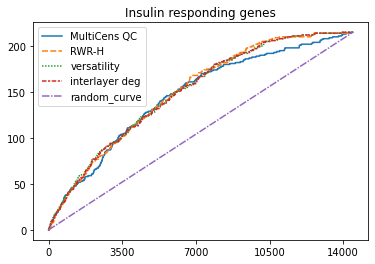

In [30]:
# Generate recall-at-k plot

plt.rcParams.update({'font.size': 10})
plt.title("Insulin responding genes")

plot_df,results, filtered_results, lncRNA_results, merged_df = plot_k_curve_new(genes, g, local_cen_vector, global_cen_vector, target_layer_cen_vector, ground_truth_genes=common_target_genes, filtered=False)

In [19]:
hormone_name = "insulin"

In [20]:
# Save lncRNA rankings, secretory gene rankings, and all genes rankings

lncRNA_results.to_csv("../data/paper/" + hormone_name + "_responding_lncRNA_results_corr_SNAP.csv")

filtered_results.to_csv("../data/paper/" + hormone_name + "_responding_fileterd_results_corr_SNAP_0.9.csv")

results.to_csv("../data/paper/" + hormone_name + "_responding_results_corr_SNAP_0.9.csv")

# To check the robustness of the method

In [19]:
# Load all genes in the skeletal muscle tissue and their variance

muscle_tissue_variance_total = pd.read_csv("../muscle_gene_variance.csv", index_col=0)

In [22]:
# Bin muscle genes based on their variance

def get_muscle_tissue_variance(df1, genes):
    df2 = df1.loc[genes].dropna()
    df2 = df2.reindex(genes)
    df2["target_variances_bins"] = pd.cut(df2["x"], bins=[-np.inf, df2["x"].quantile(0.33), df2["x"].quantile(0.66), np.inf], labels=["low", "medium", "high"])
    return df2
muscle_tissue_variance = get_muscle_tissue_variance(muscle_tissue_variance_total, genes)


In [24]:
# Sample a random set of genes
import random

def select_rows_random_excluding_stratified(df2,target_genes_indices):
    # Get the same number of rows as in the source_gene_indices list, but chosen randomly, excluding the rows corresponding to source_gene_indices and stratified by df2["source_variances_bins"]
    #all_indexes = df2.index
    all_indexes = set(df2.index)
    target_genes_indices = set(target_genes_indices)
    #diff_indexes = [index for index in all_indexes if index not in source_genes_indices]
    diff_indexes = list(all_indexes - target_genes_indices)
    low_indexes = [index for index in diff_indexes if df2.loc[index]["target_variances_bins"] == "low"]
    medium_indexes = [index for index in diff_indexes if df2.loc[index]["target_variances_bins"] == "medium"]
    high_indexes = [index for index in diff_indexes if df2.loc[index]["target_variances_bins"] == "high"]
    
    print("index count")
    print(len(low_indexes))
    print(len(medium_indexes))
    print(len(high_indexes))
    
    target_genes_indices_low = len([index for index in target_genes_indices if df2.loc[index]["target_variances_bins"] == "low"])
    target_genes_indices_medium = len([index for index in target_genes_indices if df2.loc[index]["target_variances_bins"] == "medium"])
    target_genes_indices_high = len([index for index in target_genes_indices if df2.loc[index]["target_variances_bins"] == "high"])
    print("Number of low values: ", target_genes_indices_low)
    print("Number of medium values: ", target_genes_indices_medium)
    print("Number of high values: ", target_genes_indices_high)
    
    # Selecting the same number of random indexes from each bin as there are in source_gene_indices in that bin
    random.shuffle(low_indexes)
    random.shuffle(medium_indexes)
    random.shuffle(high_indexes)
    random_indexes = low_indexes[:target_genes_indices_low] + medium_indexes[:target_genes_indices_medium] + high_indexes[:target_genes_indices_high]
    #df2.loc[random_indexes]
    return random_indexes

In [26]:
random_target_genes_indices = select_rows_random_excluding_stratified(muscle_tissue_variance.reset_index(drop=True),target_genes_indices)

index count
4362
4434
4582
Number of low values:  121
Number of medium values:  49
Number of high values:  37


In [ ]:
random_target_genes = [muscle_tissue_variance.index.tolist()[x] for x in random_target_genes_indices]
random_target_genes

In [28]:
# Load all lncRNAs

lncRNAs = list(np.load("../data/paper/lncRNAs.npy"))

lncRNA_indices = []

# Iterate over lncRNAs
for i, lncRNA in enumerate(lncRNAs):
    # Check if the current lncRNA is present in the genes list
    if lncRNA in genes:
        # Get the index of the current lncRNA in the genes list
        index = genes.index(lncRNA)
        # Append the index to the lncRNA_indices list
        lncRNA_indices.append(index)
len(lncRNA_indices)

605

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error two minor releases later


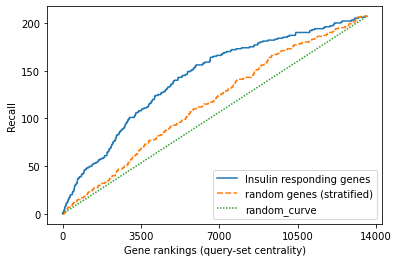

In [30]:
# Generate recall-at-k plot

def get_hits(k_range, ranked_genes, ground_truth_genes):
    hits=np.zeros_like(k_range)
    current_hit_count = 0
    for i in k_range:
        if ranked_genes[i] in ground_truth_genes:
            current_hit_count = current_hit_count +1
        hits[i] = current_hit_count
    return hits



ground_truth_genes_random = [muscle_tissue_variance.index.tolist()[x] for x in random_target_genes_indices]
ground_truth_genes_target = common_target_genes

cen_vector = g

order = cen_vector[:n].argsort()
ranks = order.argsort()
d = {'gene_name': genes, 'centrality': cen_vector[:n], 'rank': n-ranks}
results = pd.DataFrame(data=d)
results = results.sort_values(by=['centrality'], ascending=False)
ranked_genes = results['gene_name'].tolist()

k_range = np.arange(n)


hits_random = get_hits(k_range, ranked_genes, ground_truth_genes_random)
hits_target = get_hits(k_range, ranked_genes, ground_truth_genes_target)


random_curve = np.cumsum(np.full((n,), hits_target[-1]/n))
#plot_variables = {'local-cen':local_hits, 'global-cen':global_hits, 'target-layer-cen':target_layer_hits, 'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter': interlayer_deg_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
#plot_variables = {'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
#plot_variables = {'query-set centrality': hits, 'RWR': rwr_hits, 'vers': vers_hits, 'vers-target': vers_target_hits, 'inter-target': interlayer_deg_target_hits, 'random_curve': random_curve}
plot_variables = {'Insulin responding genes': hits_target, 'random genes (stratified)': hits_random, 'random_curve': random_curve}
plot_df = pd.DataFrame(data=plot_variables)
sns.lineplot(data=plot_df)    
#plt.xlabel("Top k predictions", labelpad=1)
#plt.ylabel("Recall at k", labelpad=1)
plt.rcParams.update({'font.size': 8})
plt.xlabel("Gene rankings (query-set centrality)")
plt.ylabel("Recall")
plt.xticks(np.arange(0, 15001, 3500))
plt.savefig("./insulin_responding_random_results.svg", dpi=300, fontsize=17, bbox_inches = 'tight')